# RAYG GEE

The purpose of this workbook is ...

Install R packages.

In [129]:
#######################
## Install packages. ##
#######################
install.packages( "pacman" )
library( pacman )
pacman::p_load(
    bigrquery
    ,ggplot2
    ,tidyverse
)
Sys.setenv(DOWNLOAD_STATIC_LIBV8 = 1)
install.packages("V8")
remotes::install_github("jtextor/dagitty/r")
library(dagitty)
require('IRdisplay', quietly = TRUE)
display_dagitty <-
function(
    data = NULL,
    path = NULL,
    height = 500,
    width = NULL,
    mutable = FALSE
) {
    if (!is.null(path)) {
        if (!is.null(data)) {
            stop('Please provide either `data` or `path`, not both.')
        }
        data = paste(readLines(path), collapse=  ' ')
    }
    bundle <- list(
        data=list(
            'application/x.dagitty.dag' = toString(data)
        ),
        metadata=list(
            height = ifelse(is.null(height), 'unset', paste0(height, 'px')),
            width = ifelse(is.null(width), 'unset', paste0(width, 'px')),
            mutable = mutable
        )
    )
    IRdisplay::publish_mimebundle(bundle$data, bundle$metadata)
}

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

Skipping install of 'dagitty' from a github remote, the SHA1 (8a8fd72a) has not changed since last install.
  Use `force = TRUE` to force installation



Set and load requisites.

In [337]:
##############################
## Set and load requisites. ##
##############################

# Setup connection to GCP.
project_id = "yhcr-prd-phm-bia-core"
con <- DBI::dbConnect( drv = bigquery(), project = project_id ) %>% suppressWarnings()

# Define R tibbles from GCP tables.
#r_tbl_srcode <- dplyr::tbl( con, dbplyr::in_schema( sql( "CB_FDM_PrimaryCare" ), sql( "tbl_srcode" ) ) )
r_tbl_srcode <- dplyr::tbl( con, "CB_FDM_PrimaryCare.tbl_srcode" )
r_tbl_srpatient <- dplyr::tbl( con, "CB_FDM_PrimaryCare.tbl_srpatient" )
r_tbl_BNF_DMD_SNOMED_lkp <- dplyr::tbl( con, "CB_LOOKUPS.tbl_BNF_DMD_SNOMED_lkp" )
r_tbl_srprimarycaremedication <- dplyr::tbl( con, "CB_FDM_PrimaryCare.tbl_srprimarycaremedication" )
r_tbl_srappointment <- dplyr::tbl( con, "CB_FDM_PrimaryCare.tbl_srappointment" )

# Clinical code lists (BNF, SNOMED-CT, etc).
# ## Medication codes.
codes_SNOMED_diagnoses_of_interest <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-dmtype2_cod-20200812.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_test_of_interest <-
    readr::read_csv(file = paste0( 'codelists/', 'opensafely-glycated-haemoglobin-hba1c-tests-3e5b1269.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_BNF_metformin <-
    readr::read_csv(file = paste0( 'codelists/', 'ciaranmci-metformin-bnf-0601022b0-and-child-bnf-codes-only-43e7d87e.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
names_metformin_meds <-
    r_tbl_BNF_DMD_SNOMED_lkp %>%
    dplyr::filter( BNF_Code %in% codes_BNF_metformin ) %>%
    dplyr::select( DMplusD_ProductDescription )
BNF_meds_of_interest <-
    readr::read_csv(file = paste0( 'codelists/', 'ciaranmci-bnf-section-61-drugs-for-diabetes-207573b7.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )
codes_BNF_meds_of_interest <-
    BNF_meds_of_interest$code
# ## ## Aggregate the medications to the first nine digits of their BNF codes.
names_meds_of_interest <-
    r_tbl_BNF_DMD_SNOMED_lkp %>%
    dplyr::filter( BNF_Code %in% codes_BNF_meds_of_interest ) %>%
    dplyr::select( BNF_Code, DMplusD_ProductDescription ) %>%
    dplyr::mutate(
        BNF_Code_short = stringr::str_sub( BNF_Code, end = 9 )
        ) 
shortNames_meds_of_interest <-
    names_meds_of_interest %>%
    dplyr::collect() %>%
    dplyr::left_join(
         BNF_meds_of_interest %>% filter(nchar(code) == 9)
        ,by = join_by( BNF_Code_short == code )
    ) %>%
    dplyr::select( -c( BNF_Code, BNF_Code_short ) ) %>%
    dplyr::rename(
        drug_name = DMplusD_ProductDescription
        ,drug_name_short = term
    ) %>%
    dplyr::distinct()

# ## Did-not-attend.
codes_SNOMED_didNotAttend <-
    readr::read_csv(file = paste0( 'codelists/', 'ciaranmci-did-not-attend-098119da.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code

# Load the CSV file containing that matches all medications in `codes_SNOMED_diagnoses_of_interest`
# with an expected duration of prescription.
##meds_expected_prescription_duration <-
 ##   readr::read_csv(file = 'meds_expected_prescription_duration.csv',
  ##                  col_types = cols( term = col_character(), duration = col_numeric() ) )

# Study dates
date_diagnosis_threshold <- lubridate::ymd('2000-01-01')
date_followup_start <- lubridate::ymd('2010-01-01')
date_followup_end <- lubridate::ymd('2019-12-31')

# Duration of months after the first prescription that we ignore before studying patterns.
pattern_delay_months <- 0

# Threshold value for the test, which in this case is HbA1c.
val_test_threshold <- 48

# Threshold for the expected interval between subsequent tests, in months
val_testing_interval_LB <- 2
val_testing_interval_UB <- 5

# Set values for meaningful changes in the values of the test.
val_meaningful_test_improvement <- -10
val_meaningful_test_disimprovement <- 10

# Set window within which to search for repeated (but not repeat) prescriptions.
window_repeated_prescription_months <- 3

# Set number of tests, treatments, or iterations after diagnosis that should be tracked.
n_iterations <- 10

# Set ordering of factors labels for the event variable.
df_event_factor <-
    data.frame(
        event_fct_order =
            factor(
                c( "Test Status = Red", "Test Status = Amber"
                  ,"Test Status = Yellow", "Test Status = Green" )
                ,levels = c( "Test Status = Red", "Test Status = Amber"
                            ,"Test Status = Yellow", "Test Status = Green" )
            )
        ,event_colours_order = c( "firebrick1", "darkorange", "gold", "limegreen" )
    )

# Set ordering of H.M.A. stratification.
df_HMA_factor <-
    data.frame(
        HMA_fct_order =
            factor(
                c("Hold", "Monitor", "Adjust", "Unobserved")
                ,levels = c("Hold", "Monitor","Adjust", "Unobserved")
            )
        ,HMA_colours_order = c( "plum1", "lightcoral", "cornflowerblue", "grey" )
    )

Auto-refreshing stale OAuth token.



Define study cohort.

This was trivial in previous iterations because I relied on clinicall-coded diagnoses, only. This time I will also permit diagnosis to be indicated by abnormal HbA1c (i.e. >48 mmol/mol). The justification is that concurrent work by CMI and colleagues shows that clinicall-coded dates of diabetes diagnosis disagree with HbA1c values by more than 10 years. The HbA1c values are surperior indicators but the validity of HbA1c values decreases as we go further back in the record because they weren't used diagnostically until a while after introduction. Therefore, in the early days, we will have to trust the clinically-coded date.

In an email sent 26th July 2024, CB suggested a three-option algorthin for identifying the date of diagnosis:
1. If the clinically-coded diagnosis is <u>before</u> April 2004 AND there are raised HbA1c values <u>after</u> April 2003 (note the difference in years), then use the clinically-coded date.
    - The actual statement from CB was: if the clinically-coded diagnosis is before April 2004 AND some "recent" raised HbA1c, then use the clinically-coded date, on the assumption that the date is not miscoded. This requries a threshold for "recent" (or does he mean "concurrent"?).
2. If the clinically-coded diagnosis is <u>after</u> April 2004 AND there are raised HbA1c values before April 2003 (note the difference in years), then use the earliest raised HbA1c date.
3. If the clinically-coded diagnosis is <u>after</u> April 2004 AND the first raised HbA1c value is after April 2003 (note the difference in years), then use the clinically-coded date.

My approach to identifying the date of diagnosis will be to start with the original method of using clinical codes, and then only change the date if it satisfies option #2, above.

First, I need to convert historic A1c% values to up-to-date mmol/mol values (Formala taken from https://ebmcalc.com/GlycemicAssessment.htm). Then I will define the cohort of relevant records.

In [35]:
# First, I need to convert historic A1c% values to up-to-date mmol/mol values. Formala taken from https://ebmcalc.com/GlycemicAssessment.htm
r_tbl_srcode <-
    r_tbl_srcode %>%
    dplyr::select( person_id, dateevent, numericvalue, snomedcode ) %>%
    # Convert A1c% values to mmol/mol values. Formala taken from https://ebmcalc.com/GlycemicAssessment.htm
    dplyr::mutate(
        numericvalue = 
            dplyr::if_else(
                ( snomedcode %in% codes_SNOMED_test_of_interest ) & sql("REGEXP_CONTAINS( numericvalue, r'\\.')" )
                ,( numericvalue %>% as.numeric() %>% `-`( 2.15 ) ) %>% `*`( 10.929 ) %>% as.character()
                ,numericvalue
            )
    )

In [36]:
####################
## Define cohort. ##
####################
qry_records_with_T2DM_diagnoses_coded <-
    r_tbl_srcode %>%
    # Identify records with a clinical code for Type 2 Diabetes Mellitus.
    dplyr::filter( snomedcode %in% codes_SNOMED_diagnoses_of_interest ) %>%
    dplyr::group_by( person_id ) %>%
    dplyr::summarise( date_coded_diagnosis = min( dateevent, na.rm = TRUE ) ) %>%
    dplyr::ungroup() %>%
    dplyr::select( person_id, date_coded_diagnosis ) %>%
    # Identify records whose clinically-coded date of diagnosis is after April 2004.
    dplyr::mutate(
        coded_diagnosis_before_April2004 =
            dplyr::if_else(
                ( date_coded_diagnosis < '2004-04-01' )
                ,TRUE
                ,FALSE
            )
    )

qry_records_with_T2DM_diagnoses_HbA1c <-
    r_tbl_srcode %>%
    dplyr::filter( snomedcode %in% codes_SNOMED_test_of_interest) %>%
    dplyr::select( person_id, dateevent, numericvalue ) %>%
    # Filter for raised test scores.
    dplyr::filter( as.numeric( numericvalue ) > 48 ) %>%
    # Identify records with raised HbA1c values before April 2003.
    dplyr::mutate(
        raised_HbA1c_before_April2003 =
            dplyr::if_else(
                ( dateevent  < '2003-04-01' )
                ,TRUE
                ,FALSE
            )
    ) %>%
    # Filter for the earliest test that has satisfied the criteria so far.
    dplyr::group_by( person_id ) %>%
    dplyr::filter( dateevent == min( dateevent ) ) %>%
    # Filter for the largest score because, sometimes, a patient has two tests on the same date, one of which seems spuriously low.
    dplyr::filter( as.numeric( numericvalue ) == max( as.numeric( numericvalue ) ) ) %>%
    dplyr::ungroup() %>%
    # Tidy up.
    dplyr::rename( date_HbA1c_diagnosis = dateevent)

qry_records_with_T2DM_diagnoses <-
    # Join the two query results.
    qry_records_with_T2DM_diagnoses_coded %>%
    dplyr::left_join( qry_records_with_T2DM_diagnoses_HbA1c, by = join_by( person_id ) ) %>%
    # Choose the date based on CB's definitions.
    dplyr::mutate(
        date_diagnosis = 
            dplyr::case_when(
                is.na( date_HbA1c_diagnosis ) ~ date_coded_diagnosis
                ,is.na( date_coded_diagnosis ) ~ date_HbA1c_diagnosis
                # Option 1.
                ,( coded_diagnosis_before_April2004 == TRUE ) & ( raised_HbA1c_before_April2003 == FALSE ) ~ date_coded_diagnosis
                # Option 2.
                ,( coded_diagnosis_before_April2004 == FALSE ) & ( raised_HbA1c_before_April2003 == TRUE ) ~ date_HbA1c_diagnosis
                # Option 3.
                ,( coded_diagnosis_before_April2004 == FALSE ) & ( raised_HbA1c_before_April2003 == FALSE ) ~ date_coded_diagnosis

                ,TRUE ~ NA_character_
            )
    ) %>%
    # Filter for records who diagnosis date is before the threshold.
    dplyr::filter( date_coded_diagnosis <= date_diagnosis_threshold ) %>%
    # Tidy up.
    dplyr::select( person_id, date_diagnosis )

Retrieve dates of prescriptions in the follow-up period.

In [37]:
##################################################################
## Retrieve dates of prescriptions within the follow-up period. ##
##################################################################
qry_log_prescription_longFormat <-
    qry_records_with_T2DM_diagnoses %>%
    dplyr::left_join( r_tbl_srprimarycaremedication, by = join_by( person_id ) ) %>% 
    # Select every record that has a prescription for any diabetes medication.
    dplyr::inner_join( names_meds_of_interest, by = join_by( nameofmedication == DMplusD_ProductDescription ) ) %>%
    # Filter for records within the follow-up period.
    dplyr::filter( dplyr::between( dateevent, date_followup_start, date_followup_end ) ) %>%
    dplyr::select( person_id, date_diagnosis, dateevent, nameofmedication ) %>%
    dplyr::distinct() %>%
    # Filter for however many subsequent prescriptions were specified in `n_iteraions`, then number them.
    dplyr::group_by( person_id ) %>%
    dbplyr::window_order( person_id, dateevent ) %>%
    dplyr::mutate( new_prescp_day = if_else( dateevent != lag( dateevent), 1, 0 ) ) %>%
    tidyr::replace_na( list( new_prescp_day = 1 ) ) %>%
    dplyr::mutate( i_prescrp = cumsum( new_prescp_day ) ) %>%
    dplyr::filter( i_prescrp <= n_iterations + 1 ) %>% # The "+ 1" is added so that we always include the final "Unobserved" state.
    dplyr::mutate( event_name = paste0( "prescription_", i_prescrp ) ) %>% 
    dplyr::ungroup() %>%
    # Rename columns.
    dplyr::rename(
        start_dttm = dateevent
        ,event_value = nameofmedication
    ) %>%
    # Set the end time of each prescription as the start time of the previous one.
    dplyr::group_by( person_id ) %>%
    dbplyr::window_order( person_id, start_dttm ) %>%
    dplyr::mutate( end_dttm = dplyr::if_else( person_id != lag( person_id ), start_dttm, lead( start_dttm ) ) ) %>%
    dplyr::mutate( end_dttm = dplyr::if_else( is.na( end_dttm ), start_dttm, end_dttm ) ) %>%
    dplyr::ungroup() %>%
    # Tidy up.
    dplyr::select( person_id, start_dttm, event_name, event_value, end_dttm )

Retrieve dates of tests in the follow-up period.

In [38]:
##########################################################
## Retrieve dates of tests within the follow-up period. ##
##########################################################
qry_log_prescription_longFormat <-
    qry_records_with_T2DM_diagnoses %>%
    dplyr::left_join( r_tbl_srprimarycaremedication, by = join_by( person_id ) ) %>% 
    # Select every record that has a prescription for any diabetes medication.
    dplyr::inner_join( names_meds_of_interest, by = join_by( nameofmedication == DMplusD_ProductDescription ) ) %>%
    # Filter for records within the follow-up period.
    dplyr::filter( dplyr::between( dateevent, date_followup_start, date_followup_end ) ) %>%
    dplyr::select( person_id, date_diagnosis, dateevent, nameofmedication ) %>%
    dplyr::distinct() %>%
    # Filter for however many subsequent prescriptions were specified in `n_iteraions`, then number them.
    dplyr::group_by( person_id ) %>%
    dbplyr::window_order( person_id, dateevent ) %>%
    dplyr::mutate( new_prescp_day = if_else( dateevent != lag( dateevent), 1, 0 ) ) %>%
    tidyr::replace_na( list( new_prescp_day = 1 ) ) %>%
    dplyr::mutate( i_prescrp = cumsum( new_prescp_day ) ) %>%
    dplyr::filter( i_prescrp <= n_iterations + 1 ) %>% # The "+ 1" is added so that we always include the final "Unobserved" state.
    dplyr::mutate( event_name = paste0( "prescription_", i_prescrp ) ) %>% 
    dplyr::ungroup() %>%
    # Rename columns.
    dplyr::rename(
        start_dttm = dateevent
        ,event_value = nameofmedication
    ) %>%
    # Set the end time of each prescription as the start time of the previous one.
    dplyr::group_by( person_id ) %>%
    dbplyr::window_order( person_id, start_dttm ) %>%
    dplyr::mutate(
        end_dttm = dplyr::if_else( person_id != lag( person_id ), start_dttm, lead( start_dttm ) )
    ) %>%
    dplyr::mutate( end_dttm = dplyr::if_else( is.na( end_dttm ), start_dttm, end_dttm )  )%>%
    dplyr::ungroup() %>%
    # Tidy up.
    dplyr::select( person_id, start_dttm, event_name, event_value, end_dttm )

In [39]:
######################################################
## Retrieve dates of tests in the follow-up period. ##
######################################################
qry_log_test_longFormat <- 
    qry_records_with_T2DM_diagnoses %>%
    dplyr::left_join( r_tbl_srcode, by = join_by( person_id ) ) %>% 
    # Filter records for only those that refer to the test of interest.
    dplyr::filter( snomedcode %in% codes_SNOMED_test_of_interest ) %>% 
    # Extract the required fields.
    dplyr::select( person_id, dateevent, numericvalue ) %>%
    dplyr::distinct() %>%
    # Filter out test scores of 0, which are expected to be data entry anomalies, given my selection of columns.
    dplyr::filter( numericvalue != "0" ) %>%
     # Filter for records within the follow-up period.
    dplyr::filter( dplyr::between( dateevent, date_followup_start, date_followup_end ) ) %>%
    # Rename columns.
    dplyr::rename(
        start_dttm = dateevent
        ,event_value_numeric = numericvalue
    ) %>% 
    # Filter for however many subsequent tests were specified in `n_iteraions`, then number them.
    dplyr::group_by( person_id ) %>% 
    dbplyr::window_order( start_dttm ) %>% 
    dplyr::filter( row_number() <= n_iterations + 1 ) %>% # The "+ 1" is added so that we always include the final "Unobserved" state.
    dplyr::mutate( event_name = paste0( "test_", row_number() - 1 ) ) %>% 
    dplyr::ungroup() %>% 
    # Set the end time each test as the start time of the previous one.
    dplyr::group_by( person_id ) %>%
    dbplyr::window_order( start_dttm ) %>%
    dplyr::mutate( end_dttm = lead( start_dttm ) ) %>% 
    dplyr::ungroup() %>%
    # Convert the numeric test values into labels.
    dplyr::mutate( event_value_numeric = as.numeric( event_value_numeric ) ) %>%
    dplyr::mutate(
        event_value = dplyr::case_when(
            is.na( event_value_numeric ) ~ NA_character_
            ,event_value_numeric > 70 ~ "Test Status = Red"
            ,event_value_numeric > 58  ~ "Test Status = Amber"
            ,event_value_numeric > 48 ~ "Test Status = Yellow"
            ,TRUE ~ "Test Status = Green"
            )
    ) %>%
    # Tidy up.
    dplyr::select( person_id, start_dttm, event_name, event_value, end_dttm ) %>%
    dplyr::distinct()

Create a variable to indicate the date from which we no longer observe the patient in the record.

In [40]:
# Firstly, retrieve the dates of death, if they exist, and use them to inform a variable
# called `date_unobserved` to indicate the date from which we no longer observe
# the patient in the record.
patients_of_interest_with_death_dates <-
    r_tbl_srpatient %>%
    # Select only those patients in whom we are interested.
    dplyr::inner_join( qry_records_with_T2DM_diagnoses, by = join_by( person_id ) )

if( !is.na( nrow( patients_of_interest_with_death_dates ) ) )
    {
        df_date_unobserved <-
            patients_of_interest_with_death_dates %>%
            dplyr::select( person_id, datedeath ) %>% 
            dplyr::distinct() %>%
            dplyr::collect() %>%
            tidyr::separate(
                col = datedeath
                ,sep = 4
                ,into = c( "death_year", "death_month" )
            ) %>%
            dplyr::mutate(
                date_unobserved = 
                    dplyr::if_else(
                        is.na( death_year )
                        ,NA
                        ,ISOdate( year = death_year, month = death_month, day = 1, hour = 0 )
                    )
            ) #%>%
            # If there are multiple dates of death, chose the earliest one.
            dplyr::group_by( person_id ) %>%
            dplyr::filter( if (is.na( date_unobserved ) ) min( date_unobserved, na.rm = TRUE) else date_unobserved ) %>%
            dplyr::ungroup() %>%
            # Tidy up.
            dplyr::select( person_id, date_unobserved ) %>%
            dplyr::arrange( person_id )
    } else {
        df_date_unobserved <-
            data.frame(
                person_id = integer(0)
                ,date_unobserved = Date(0)
            )
    }

Append the prescriptions and tests dataframe logs.

In [41]:
df_log_PandT_longFormat <-
    qry_log_prescription_longFormat %>%
    dplyr::union_all( qry_log_test_longFormat ) %>%
    dplyr::ungroup() %>% 
    dplyr::distinct() %>%
    dplyr::arrange( person_id, start_dttm ) %>%
    # Include a date from which we stop observing the patient in the record.
    # This will be either the date of death or one second after the `end_dttm`
    # of the last event in a patient's record.
    dplyr::collect() %>%
    dplyr::group_by( person_id ) %>%
    dplyr::group_modify( ~ tibble::add_row( .x ), .by = person_id ) %>% 
    dplyr::left_join( df_date_unobserved, by = join_by( person_id ) ) %>%
    dplyr::mutate( start_dttm = if_else( is.na( start_dttm ), date_unobserved , start_dttm ) ) %>%
    dplyr::ungroup() %>%
    # Update `event_name` so that it shows "Unobserved", where appropriate.
    dplyr::mutate( event_value = if_else( is.na( event_value ), "Unobserved", event_value ) ) %>%
    # Update `start_dttm` so that it shows one second after the last
    # `start_dttm` whenever `date_unobserved` is NA. 
    dplyr::mutate( start_dttm = if_else( is.na( start_dttm ), lag( start_dttm ) + lubridate::seconds(1), start_dttm ) ) %>%
    # Update `end_dttm` for the final observed event. It should no longer read
    # as NA because the "Unobserved" follows it 
    dplyr::mutate( end_dttm = if_else( lead( event_value ) == "Unobserved", lead( start_dttm ), end_dttm ) ) %>%
    suppressWarnings() %>%
    dplyr::select( - date_unobserved ) %>%
    dplyr::arrange( person_id, start_dttm )

Now, I create the simplified dataframe object from the first iteration (i.e. the SQL-extracted dataframe to only focus on a handful of medications because this is only an example).

In [44]:
# Simplify the event names and values.
df_log_PandT_longFormat_simplified <-
    df_log_PandT_longFormat %>%
    # Remove the numbers in the event name.
    dplyr::mutate_at(
        .vars = vars( event_name )
        ,.funs = ~ gsub( "_[0-9]", "", . )
    ) %>% 
    # Aggregate medications.
    dplyr::left_join(
        shortNames_meds_of_interest
        ,by = join_by( event_value == drug_name )
    ) %>%
    dplyr::mutate(
        event_value = dplyr::if_else( is.na( drug_name_short ), event_value, drug_name_short )
    ) %>%
    dplyr::select( -drug_name_short ) %>%
    # Convert to factor ## Can no longer do this because the factor list is too large.
    dplyr::mutate_at(
        .vars = vars( event_value )
        ,.funs = funs( factor( ., levels = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings()

Before I can beging analysing the data, I need to define the strata proposed by the Clinical Review Board. The stratifications were:
- H.M.A.: Four strata defined by combinations of {'Expected', 'Shorter-than-expected'} testing intervals and {'No observed change', 'Observed change'} in prescriptions. The H.M.A. acronym derives from the three strata: (0,0)-Hold; (1,0)-Monitor; (0 or 1, 1)-Adjust.
- Tests-and-Interventions: Twelve strata defined by combinations of the test statuses and whether the patient is on one, two or three medications simulatneously.
- Multimorbidity: Two strata defined by whether or not there is a record for at least one of the multimorbidity diagnositic codes.

The first thing I do is to add a variable that indicates the patient-specific test interval. This will be handy for bounding the variables I need to create.

In [45]:
# Create a variable that indicates patient-specific test interval.
df_log_PandT_longFormat_simplified_StrataLabels <-
    df_log_PandT_longFormat_simplified %>%
    dplyr::group_by( person_id ) %>%
    dplyr::arrange( start_dttm ) %>%
    dplyr::mutate(
        idx_test_interval = 0 + cumsum( stringr::str_detect( event_value, pattern = "Test" ) )
    ) %>% 
    dplyr::ungroup() %>%
    # Remove any record with `idx_test_interval` == 0, which indicates no tests on record.
    dplyr::filter( idx_test_interval != 0 ) %>%
    # Remove any calculated `idx_test_interval` for which the `event_value` is "Unobserved".
    dplyr::mutate_at(
        .vars = vars( idx_test_interval )
        ,.funs = funs(
            dplyr::if_else( event_value == "Unobserved", NA_integer_, . )
        )
    ) %>%
    suppressWarnings() %>%
    # Tidy up.
    dplyr::distinct() %>%
    dplyr::arrange( person_id, start_dttm )

__H.M.A. stratification__

The two components of this stratification are the testing interval and the change in prescription. The testing interval requries me to create a variable indicating that the inter-test duration was between `val_testing_interval_LB` and `val_testing_interval_UB`. The change in prescription requires me to create a variable indicating whether the prescriptions before and after an index test event are the same.

The first thing is to calculate the inter-test duration. In this iteration, I will have to ignore the interval between the diagnostic test and the subsequent test because I am deliberately looking at records ten years after the diagnostic test.

In [46]:
df_inter_test_duration <-
    qry_log_test_longFormat %>%
    dplyr::filter( event_name != "diagnosis" ) %>%
    # Calculate the duration between each test and the next.
    dplyr::mutate( inter_test_duration_cont = sql( "DATE_DIFF( end_dttm, start_dttm, MONTH )" ) ) %>%
    # If the event is a diagnosis, then I need to calculate the inter-test duration in a different way.
    dplyr::group_by( person_id ) %>%
    dplyr::mutate(
        inter_test_duration_cont =
            dplyr::if_else(
                event_name == "diagnosis"
                ,sql( "DATE_DIFF( LEAD( start_dttm ) OVER( PARTITION BY person_id ORDER BY start_dttm ASC), start_dttm, MONTH )" )
                ,inter_test_duration_cont
            )
    ) %>%
    dplyr::ungroup() %>%
    # Make any same-day tests or anomalies = NA.
    dplyr::mutate(
        inter_test_duration_cont = 
            dplyr::if_else(
                inter_test_duration_cont == 0
                ,NA_real_
                ,inter_test_duration_cont
            )
    ) %>%
    # Create a discretised version of the inter-test duration variable.
    dplyr::mutate(
        inter_test_duration_discr =
            dplyr::if_else(
                ( inter_test_duration_cont > val_testing_interval_LB ) & ( inter_test_duration_cont < val_testing_interval_UB )
                ,"Shorter than expected"
                ,"As expected"
            )
    ) %>%
    # Make any same-day tests or anomalies = NA.
    dplyr::mutate(
        inter_test_duration_discr =
             dplyr::if_else(
                 inter_test_duration_cont == 0
                 ,NA_character_
                 ,inter_test_duration_discr
             )
    ) %>%
    # Tidy up.
    dplyr::filter( !is.na( inter_test_duration_cont ) ) %>%
    arrange( person_id, start_dttm ) %>%
    dplyr::select( c( person_id, start_dttm
                     ,inter_test_duration_cont, inter_test_duration_discr ) ) %>% 
    dplyr::distinct()

# Add the new variable to the dataframe.
df_log_PandT_longFormat_simplified_StrataLabels <-
    # Join the variable indicating the inter-test duration.
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    dplyr::left_join(
        df_inter_test_duration %>% dplyr::collect()
        ,by = join_by( person_id, start_dttm )
        ,relationship = "many-to-many"
        # The `relationship` argument is needed because a warning is raised happens for the situations
        # where multiple prescriptions are given on the same day.
    ) %>%
    # Fill in the values of the inter-test variables into subsequent rows until a new value is given.
    dplyr::group_by( person_id ) %>%
    dplyr::arrange( start_dttm ) %>%
    tidyr::fill( inter_test_duration_cont ) %>%
    tidyr::fill( inter_test_duration_discr ) %>%
    dplyr::ungroup()

Next, I need to make the variable that indicates whether the prescription has changed since the previous interval.

In [47]:
df_log_PandT_longFormat_simplified_StrataLabels <-
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    # Create new columns that contain either the test events or the prescription events.
    dplyr::select( person_id, start_dttm, event_value, idx_test_interval ) %>%
    dplyr::mutate(
        tempCol_tests = dplyr::if_else( stringr::str_detect( event_value, pattern = "Test"), event_value, NA_character_ )
    ) %>%
    dplyr::mutate(
        tempCol_prescrps = dplyr::if_else( !stringr::str_detect( event_value, pattern = "Test"), event_value, NA_character_ )
    ) %>%
    # Fill the test column until a new value is given.
    dplyr::arrange( person_id, start_dttm ) %>%
    tidyr::fill( tempCol_tests ) %>%
    # Tidy away unecessary columns.
    dplyr::select( - c( event_value, start_dttm ) ) %>%
    # Remove repeated prescriptions within an inter-test period.
    dplyr::distinct() %>%
    # Pivot wider so that each row represents an inter-test period.
    dplyr::group_by( person_id, tempCol_tests ) %>%
    dplyr::mutate( rn = row_number() ) %>%
    dplyr::ungroup() %>%
    tidyr::pivot_wider(
        names_from = rn
        ,values_from = tempCol_prescrps
        ) %>% 
    # List-concatonate the repeated prescriptions into one string
    tidyr::unite(
        col = "meds_set"
        ,dplyr::select(
            .
            ,- c('person_id', 'tempCol_tests', 'idx_test_interval')
        ) %>% colnames()
        ,sep = ","
        ,na.rm = TRUE
    ) %>%
    # Check subsequent rows for a match.
    dplyr::group_by( person_id ) %>% 
    dplyr::mutate( prev_meds_set = lag( meds_set ) ) %>%
    dplyr::ungroup() %>%
    dplyr::mutate_at(
        .vars = vars( meds_set, prev_meds_set )
        ,.funs = funs( strsplit( ., ',') )
    ) %>% 
    dplyr::rowwise() %>%
    dplyr::mutate(
        new_meds =
            dplyr::if_else(
                is.na( prev_meds_set[1] )
                ,"",
                toString( setdiff( meds_set, prev_meds_set ) ) 
                ) %>% nchar() != 0
    ) %>%
    dplyr::ungroup() %>%
    suppressWarnings() %>%
    # Join the `new_meds` column to the original dataframe.
    dplyr::select( person_id, idx_test_interval, new_meds ) %>%
    dplyr::right_join(
        df_log_PandT_longFormat_simplified_StrataLabels
        ,by = join_by( person_id, idx_test_interval )
    )

The final step is to combine the two components of the stratification's definition into a single variable called HMA.

In [48]:
df_log_PandT_longFormat_simplified_StrataLabels <-
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    dplyr::mutate(
        HMA =
            dplyr::case_when(
                event_value == "Unobserved" ~ "Unobserved"

                ,( inter_test_duration_discr == "As expected" & new_meds == FALSE ) ~ "Hold"
                ,( inter_test_duration_discr == "Shorter than expected" & new_meds == FALSE ) ~ "Monitor"
                ,( new_meds == TRUE ) ~ "Adjust"

                ,TRUE ~ NA_character_
            )
    ) %>%
    # Set as a factor datatype and order the factors.
    dplyr::mutate( HMA = factor( HMA, levels = df_HMA_factor %>% dplyr::select( HMA_fct_order ) %>% dplyr::pull() ) )

Prepare a dataset for the Generalised Estimating Equation. Keep in mind that the `test_status` variable is ordered 1 to 4 from Green to Red, and the HMA variable is ordered 1 to 3 from Hold to Adjust.

In [154]:
gee_dataset <-
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    dplyr::distinct( person_id, event_value, HMA) %>%
    dplyr::filter( stringr::str_detect( event_value, pattern = "Test" ) ) %>%
    dplyr::mutate( event_value = event_value %>% droplevels() %>% ordered() ) %>%
    dplyr::mutate( HMA = HMA %>% droplevels() ) %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate( rn = row_number() ) %>%
    dplyr::ungroup() %>%
    dplyr::arrange( person_id, rn ) %>%
    dplyr::group_by( person_id ) %>%
    dplyr::rename(
        test_status = event_value
        ,previous_HMA_state = HMA
    ) %>%
    dplyr::mutate( previous_test_status = lag( test_status ) ) %>%
    dplyr::ungroup() 

gee_dataset %>% head()

person_id,test_status,previous_HMA_state,rn,previous_test_status
<int>,<ord>,<fct>,<int>,<ord>
1168,Test Status = Red,Hold,1,NA
1168,Test Status = Red,Monitor,2,Test Status = Red
1168,Test Status = Amber,Hold,3,Test Status = Red
1243,Test Status = Yellow,Hold,1,NA
1619,Test Status = Green,Hold,1,NA
1619,Test Status = Red,Hold,2,Test Status = Green


## Specifying the parameters.
There are several parameters that must be specified to fit the Generalised Estimating Equation:
1. local odds ratio structure
2. link function
3. covariates
4. form of covariate

### 1. Choosing the local odds ratio structure.
The local odds ratio structure is the equivalent of the covariance structure in a standard GEE. That is to say, the local odds ratio structure sets up what I assume to be the dependency / association between the repeated observations. Repeated observations are grouped into 'blocks' - in our case, based on `person_id` - and then we have to decide:
1. how we assume the repeated observations of the variate (i.e. `test_status`) relate to each other; and
2. how the levels of the variate (i.e. {Red, Amber, Yellow, Green}) at each observation timepoint relate to each other.

Following Occam's razor, it's best to choose the simplist local odds ratio stucture that still represents the dependencies / associations between the difference levels of the variate at the repeated observation timepoints. The authors of the `multgee::ordLORgee()` function that I am using suggest that one should start by checking the range of the intrinsic parameters for the dataset. If the range is less than two, then I am probbably safe to set the local odd ratio structure to `"uniform"`, which would assume that the dependency / assocation between levels of the variate are all the same at all observation timepoints. (Note: An intrinsic parameter is a unitless measure of association inherent to the construction of local odds ratios. There is an intrinsic parameter for every adjacent 2-by-2 table that compares levels of the variate at between successive observation timepoints).

The range of the intrinsic parameters in our dataset is shown below.

In [54]:
ips <-
multgee::intrinsic.pars(
                        y = gee_dataset$test_status
                         ,data = gee_dataset
                         ,id = person_id
                         ,repeated = rn
                         ,rscale = "ordinal"
                         )
max( ips ) - min( ips )

Warning message:
“glm.fit: fitted rates numerically 0 occurred”


[1] 10.87932

The range of the intrinsic parameters is much greater than 2, so it is probably not appropriate to fit the local odds ratios structure as `"uniform"`. 

I fit the GEE using all structures that are available in the `multgee::ordLORgee()` function, and found that the local odds ratios all land around 1.00. The GEE coefficients also don't differ to any meaningful degree depending on the local odds ratio structure that is assumed. Therefore, I conclude that the choice of local odds ratio structure is not important in my case (In fact, the premise of the local-odds-ratio approach to GEEs is that the local odds ratios are nuisance parameters, so I shouldn't expect much insight from them, anyway).

Ultimately, I choose the `"time.exch"` local odds ratio structure because I think it is appropriate to assume the associations between levels of the variate are consistent over repeated observations, but that those associations are permitted to different for each pair of levels being compared. For example, the association between whether a patient's record indicated `Test Status = Green` or `Test Status = Yellow` at timepoints t1 and t2 is the same as the association at timepoints t2 and t3, but the value of the association can be different for the comparison between `Test Status = Amber` and `Test Status = Red`. My justification comes from the consistency in the proportion of transitions between test-status values, as seen in the Sankey plots from the ClearPath studies. To be clear, the `"time.exch"` structure assumes that there is a dependency / assocation between successive observations, and that the dependency / association is the same for every pair of antecedent and subsequent (similar to a Markov model).

I would have preferred to have set the `"independence"` local odds ratio structure, which would have permitted the odds ratios to vary between both variate level comparisons and timepoints, but the local odds ratios that are returned by the `multgee::ordLORgee()` function are all the same and all equal '1' exactly with no decimal places, suggesting improper estimation. This seems pathological and might be a sign of the convergence problems identified by the authors with the `"independence"` local odds ratio structure (see the second-to-last paragraph of section 6 in [Touloumis (2015)](https://www.jstatsoft.org/article/view/v064i08)). The `"time.exch"` local odds ratio structure provides plausible estimates that do not differ much from the '1' value provided by the `"independence"` local odds ratio structure.

(For future versions of this study, I might define my own, bespoke local odds ratio structure.)

### 2. Choosing the link function.
The most-common choice of link function for ordinal multinomial regression models is the cumulative logit link. For my case of a variate with four levels, the cumulative logit link function would compute the population averages for:

$$log\left(\frac{P(test\_status = Red)}{P(test\_status = \{Amber\ or\ Yellow\ or\ Green\})}\right)$$

$$log\left(\frac{P(test\_status = \{Red\ or\ Amber\})}{P(test\_status = \{Yellow\ or\ Green\})}\right)$$

$$log\left(\frac{P(test\_status = \{Red\ or\ Amber\ or\ Yellow\})}{P(test\_status = Green)}\right)$$

Note that the comparison (i.e. what is above and below the line) is between every variate level either side of a different threshold.

In contrast, the adjacent category logit compares each variate level with its adjacent level, only:

$$log\left(\frac{P(test\_status = Red)}{P(test\_status = Amber)}\right)$$

$$log\left(\frac{P(test\_status = Amber)}{P(test\_status = Yellow)}\right)$$

$$log\left(\frac{P(test\_status = Yellow)}{P(test\_status = Green)}\right)$$

I choose the adjacent category logit because I am interested in the population averages for the specific comparisons of variate levels.

### 3. Choosing the covariates.
It is crucial for unbiased inference that confounding bias is mitigated and collider bias is not induced. I use a directed acyclic graph to present my hypothesised map of how the variables associated with my research question relate to each other. From this graph, I can identify what covariates are required to mitigate confounding bias and mitigate contamination from unintentional collider bias.

The R syntax below defines the directed acyclic graph and then outputs the list of covariates that are needed to mitigate bias in the modelling of the association between test status and the previous HMA state.

In [141]:
GEE_dag <- dagitty::dagitty('
dag {
bb="0,0,1,1"
D_tminus3 [latent,pos="0.097,0.331"]
D_tminus2 [latent,pos="0.290,0.346"]
D_tminus1 [latent,pos="0.507,0.348"]
D [latent,pos="0.729,0.342"]
HMA_tminus2 [pos="0.377,0.892"]
HMA_tminus1 [exposure,pos="0.618,0.894"]
HMA [pos="0.834,0.890"]
Rx_tminus3 [pos="0.178,0.499"]
Rx_tminus2 [pos="0.375,0.507"]
Rx_tminus1 [pos="0.614,0.499"]
Rx [pos="0.836,0.516"]
test_status_tminus3 [pos="0.101,0.132"]
test_status_tminus2 [pos="0.290,0.121"]
test_status_tminus1 [adjusted,pos="0.512,0.113"]
test_status [outcome,pos="0.728,0.113"]
dT_tminus3 [pos="0.174,0.692"]
dT_tminus2 [pos="0.378,0.694"]
dT_tminus1 [pos="0.609,0.701"]
dT [pos="0.837,0.711"]
D_tminus3 -> D_tminus2
D_tminus3 -> Rx_tminus3
D_tminus3 -> dT_tminus3
D_tminus2 -> D_tminus1
D_tminus2 -> Rx_tminus2
D_tminus2 -> dT_tminus2
D_tminus1 -> D
D_tminus1 -> Rx_tminus1
D_tminus1 -> dT_tminus1
D -> Rx
D -> dT
Rx_tminus3 -> D_tminus2
Rx_tminus3 -> HMA_tminus2
Rx_tminus2 -> D_tminus1
Rx_tminus2 -> HMA_tminus2
Rx_tminus2 -> HMA_tminus1
Rx_tminus1 -> D
Rx_tminus1 -> HMA_tminus1
Rx_tminus1 -> HMA
Rx -> HMA
test_status_tminus3 -> D_tminus3
test_status_tminus3 -> test_status_tminus2
test_status_tminus2 -> D_tminus2
test_status_tminus2 -> test_status_tminus1
test_status_tminus1 -> D_tminus1
test_status_tminus1 -> test_status
test_status -> test_status
dT_tminus3 -> HMA_tminus2
dT_tminus2 -> HMA_tminus1
dT_tminus1 -> HMA
}
')
print( dagitty::adjustmentSets( GEE_dag, exposure = "HMA", outcome = "test_status", effect = "total" ) )

{ test_status_tminus1 }


The results show that I only need to include the immediately-preceding test_status as a covariate, in addition to my exposure covariate.

But, the covariate assessment is only valid if the hypothesised graph is valid. The following R syntax details the testable statistical implications of my graph, which would need to be true if my graph were valid.

In [147]:
testable_implications <- dagitty::impliedConditionalIndependencies( GEE_dag )
print( paste0( "There are ", testable_implications %>% length(), " testable implications." ) )

[1] "There are 64 testable implications."


In [ ]:
###### TEST THE TESTABLE IMPLICATIONS

### 4. Form of covariates.
Now that I have identified my covariates, I need to choose how best to represent that covariate in the GEE.

Both covariates `previous_HMA_status` and `previous_test_status` are ordinal factors. I could represent them as numeric covariates, which would provide a single coefficient for me to interpret the population-averaged log-odds test-status values. The caveat is that this coefficient represents the population-averaged log-odds corresponding to a 1-unit difference in the covariate, on average, so:
1. I can't if there are differences between any particular pairing of the covariate levels (e.g. Hold-vs-Monitor compare to Monitor-vs-Adjust),
2. I can't know about greater-than-1-unit changes (e.g. Hold-vs-Adjust, which skips the Monitor level), and
3. technically, the coefficient applies to nonsensical values of the covariate beyond the numeric range that don't exist (e.g. Hold = 1 but the coefficient is averaged of values up to infinity for which there is no HMA state).

The alternative is to represent the covariates with dummy encoding. The benefit is that each coefficient can be interpreted as the population-averaged log-odds of the test-status value comparing specific pairs of levels of the covariate. Specifically, each dummy variable encodes the log-odds for comparison to a reference value. The disadvantage of this representation is that I will have to run multple estimations with different the reference values to estimate the population-averaged log-odds for all possible pairs of levels of the covariate.

Based on these considerations:
1. I will use the dummy encoding for the exposure covariate, so that I can estimate pair-specific specific population-averaged log-odds.
2. I will use the dummy encoding for the confounding-adjustment covariate, because this is the lagged-by-1 variate value that is already being represented non-numerically.

## Fit the model.
I want to estimate the following population-averaged log-odds for the `previous_HMA_state` covariate:
1. Hold-vs-Monitor (Hold as reference)
2. Hold-vs-Adjust (Hold as reference)
3. Monitor-vs-Adjust (Monitor as Monitor)

Odds are symmetrical, so estimating these three log-odds means I immediately know the opposite odds. For example, if the odds ratio for Hold-vs-Monitor (Hold as reference is 1.2, then this means that the Monitor state is 1.2-times the odds of the Hold state AND that the Hold state is approximately 0.8-times the odds of the Monitor state.

To estimate these coefficients, I need to run the same GEE specification but:
1. GEE_holdAsReferenceLevel will have Hold as the reference level in `previous_HMA_state`, and 
2. GEE_monitorAsReferenceLevel will have Monitor as the reference level in `previous_HMA_state`.

In [257]:
GEE_holdAsReferenceLevel <-
multgee::ordLORgee(
        formula = test_status ~ previous_HMA_state + previous_test_status
        ,link = "acl"
        ,id = person_id
        ,repeated = rn
        ,data = gee_dataset %>% 
                    dplyr::mutate(
                        previous_HMA_state = relevel( as.factor( previous_HMA_state ), ref = 1 )
                    )
        ,LORstr = "time.exch"
    )
GEE_holdAsReferenceLevel_odds <- GEE_holdAsReferenceLevel %>% coef() %>% exp()
GEE_holdAsReferenceLevel_probs <- 1 / (1 + (GEE_holdAsReferenceLevel %>% coef() %>% exp()))


GEE_monitorAsReferenceLevel <-
multgee::ordLORgee(
        formula = test_status ~ previous_HMA_state + previous_test_status
        ,link = "acl"
        ,id = person_id
        ,repeated = rn
        ,data = gee_dataset %>% 
                    dplyr::mutate(
                        previous_HMA_state = relevel( as.factor( previous_HMA_state ), ref = 2 )
                    )
        ,LORstr = "time.exch"
    )
GEE_monitorAsReferenceLevel_odds <- GEE_monitorAsReferenceLevel %>% coef() %>% exp()
GEE_monitorAsReferenceLevel_probs <- 1 / (1 + (GEE_monitorAsReferenceLevel %>% coef() %>% exp()))

## Checking the generalisability of the GEEs.
We need to check two p-values to understand whether our estimates are generalisable to our study population or limited to our sample.

The first is the p-value for the GEE, overall. If the p-value of the GEE is not statistically significant, then we infer that the spread of the observed data is such that none of our estimated differences in odds would are likely be found in the study population beyond our sample (even though it is the observed difference in odds within our sample). More data would need collecting or the model would need respecifying.

If the p-value of the GEE is statistically significant, then we proceed to review the estimated coefficients.

The second p-value(s)  is for the estimate of the previous HMA state.  The covariate `previous_HMA_state` is dummy coded so it has two coefficients, and thus, we have to review two p-values. If the coefficients are statistically significant, then we infer that it is likely that a difference in odds at least as large as we estimated would be found in the study population beyond our sample.

If coefficient is not statistically significant, then we infer that the spread of the observed data is such that the estimated odds ratios are statistically similar to equality, i.e. it is unlikely that a difference in odds at least as large as we estimated would be found in the study population beyond our sample (even though it is the observed difference in odds within our sample).

If we have found that both the GEE and a particular coefficient are statistically significant, then our concluding statements can be presented as inferences about the study population; if not, then our concluding statements must be presented as descriptions about the study sample.

The p-values are presented below.

In [178]:
print("GEE_holdAsReferenceLevel")
pval_extraction <- summary( GEE_holdAsReferenceLevel ) %>% `[`( c("pvalue", "coefficients"))
pval_model <- pval_extraction$pvalue %>% as.numeric()
pval_coeffs <- pval_extraction$coefficients[ c('previous_HMA_stateMonitor', 'previous_HMA_stateAdjust'), 'Pr(>|san.z|)']
pvals <- c(pval_model, pval_coeffs)
ifelse( pvals < 0.0001, "< 0.0001", pvals)

print("GEE_monitorAsReferenceLevel")
pval_extraction <- summary( GEE_monitorAsReferenceLevel ) %>% `[`( c("pvalue", "coefficients"))
pval_model <- pval_extraction$pvalue %>% as.numeric()
pval_coeffs <- pval_extraction$coefficients[ c('previous_HMA_stateHold', 'previous_HMA_stateAdjust'), 'Pr(>|san.z|)']
pvals <- c(pval_model, pval_coeffs)
ifelse( pvals < 0.0001, "< 0.0001", pvals)

[1] "GEE_holdAsReferenceLevel"


previous_HMA_stateMonitor  previous_HMA_stateAdjust 
               "< 0.0001"                "< 0.0001"                "< 0.0001"

[1] "GEE_monitorAsReferenceLevel"


previous_HMA_stateHold previous_HMA_stateAdjust 
              "< 0.0001"               "< 0.0001"               "< 0.0001"

All p-values are lower than the default level of signficance (alpha = 0.05). Specifically, the GEEs output suggests that:
- there is less than a 1 in 10,000 chance that either GEE's coefficients are all compatible with them truly being zero.
- there is less than a 1 in 10,000 chance that any of the coefficients of interest are compatible with it truly being zero.

Since these probabilities are so low, I consider it reasonable to assume the coefficients are not truly zero. And if they are not truly zero, then the estimates from our sample are our best population estimates, for now.

### Presenting the estimated population-averaged means.
The GEEs estimate the population-averaged log-odds of test-status values, conditional on the previous test-status value and on the previous HMA state. A simple transformation provides probabilities rather than odds, for each of the HMA states. The result, shown below, is a plot of the probability of each test-status value, accounting for the covariates, for each of the value of the previous HMA state.

In [359]:
newdata_holdAsReferenceLevel <- expand.grid(
    previous_HMA_stateMonitor = c(0,1)
    ,previous_HMA_stateAdjust = c(0,1)
    ,previous_test_status.L = c(0,1)
    ,previous_test_status.Q = c(0,1)
    ,previous_test_status.C = c(0,1)
)
intercepts_holdAsReferenceLevel <-
    GEE_holdAsReferenceLevel %>%
    coef() %>%
    `[`( 1:3 ) 
covars_holdAsReferenceLevel <-
    GEE_holdAsReferenceLevel %>%
    coef() %>%
    `[`( 4:length( . ) ) %>%
    `*`( newdata_holdAsReferenceLevel ) %>%
    rowSums()
# Red: use the reciprocal of the RedToAmber intercept, plus the covariate because reciprocating makes Red = 1 and Amber = 0.
preds_Red <- exp( -intercepts_holdAsReferenceLevel[1] + covars_holdAsReferenceLevel ) / ( 1 + exp( -intercepts_holdAsReferenceLevel[1] + covars_holdAsReferenceLevel ) )
# Amber: use RedToAmber intercept, plus covariates because Red = 0 and Amber = 1.
preds_Amber <- exp( intercepts_holdAsReferenceLevel[1] + covars_holdAsReferenceLevel ) / ( 1 + exp( intercepts_holdAsReferenceLevel[1] + covars_holdAsReferenceLevel ) )
# Yellow: use AmberToYellow intercept, plus covariates because Amber = 0 and Yellow = 1.
preds_Yellow <- exp( intercepts_holdAsReferenceLevel[2] + covars_holdAsReferenceLevel ) / ( 1 + exp( intercepts_holdAsReferenceLevel[2] + covars_holdAsReferenceLevel ) )
# Green: use YellowToGreen intercept, plus covariates because Yellow = 0 and Green = 1.
preds_Green <- 1 - ( exp( intercepts_holdAsReferenceLevel[3] + covars_holdAsReferenceLevel ) / ( 1 + exp( intercepts_holdAsReferenceLevel[3] + covars_holdAsReferenceLevel ) ) )
preds <- dplyr::bind_cols(
    preds_Red = preds_Red
    ,preds_Amber = preds_Amber
    ,preds_Yellow = preds_Yellow
    ,preds_Green = preds_Green
    ,HMA_number = newdata_holdAsReferenceLevel %>%
                    dplyr::transmute(
                        HMA_state = dplyr::case_when(
                            previous_HMA_stateMonitor == 0 & previous_HMA_stateAdjust == 0 ~ 'Hold'
                            ,previous_HMA_stateMonitor == 1 & previous_HMA_stateAdjust == 0 ~ 'Monitor'
                            ,previous_HMA_stateMonitor == 0 & previous_HMA_stateAdjust == 1 ~ 'Adjust'

                            ,TRUE ~ NA
                        )
                    )
) %>%
tidyr::drop_na() %>%
pivot_longer(
    cols = !HMA_state
    ,names_to = "intercept"
    ,values_to = "Estimation"
) %>%
dplyr::group_by( HMA_state, intercept ) %>%
dplyr::mutate(
    grp_avg = mean( Estimation )
) %>%
dplyr::ungroup() %>%
# Make `intercept` into a factor and order it.
dplyr::mutate(
    intercept = factor( intercept,  levels = c( 'preds_Red', 'preds_Amber', 'preds_Yellow', 'preds_Green' ) )
) %>%
dplyr::mutate(
    HMA_state = factor( HMA_state,  levels = c( 'Hold', 'Monitor', 'Adjust' ) )
) %>%
dplyr::arrange( intercept, HMA_state )

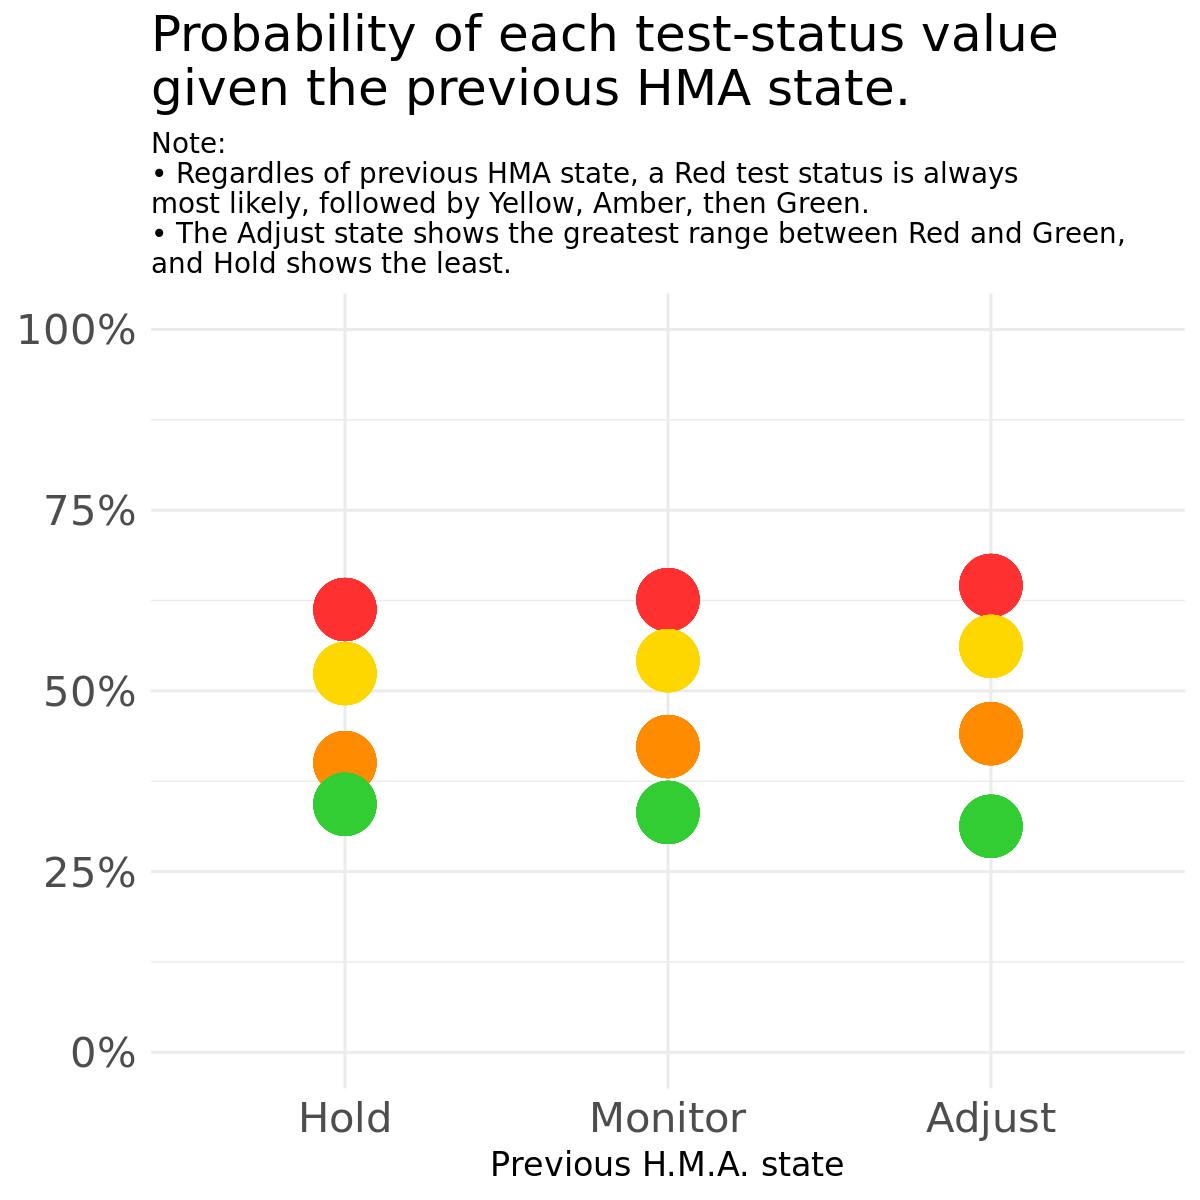

In [372]:
options( repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 200 )

preds %>%
ggplot( aes( x = HMA_state, colour = intercept ) ) +
geom_point( aes( y = grp_avg ), size = 10 ) +
scale_colour_manual(
    values =
        df_event_factor %>%
        dplyr::select( event_colours_order ) %>%
        droplevels() %>%
        dplyr::pull()
) +
labs(
    title = "Probability of each test-status value\ngiven the previous HMA state."
    ,subtitle = paste0(
        "Note: \n"
        ,"\u2022 Regardles of previous HMA state, a Red test status is always\nmost likely, followed by Yellow, Amber, then Green.\n"
        ,"\u2022 The Adjust state shows the greatest range between Red and Green,\nand Hold shows the least."
        )
    ,x = "Previous H.M.A. state"
) +
scale_y_continuous( labels = scales::percent_format(), limits = c( 0, 1 ) ) +
theme_minimal() +
theme(
    title = element_text( size = 15 )
    ,axis.title.x = element_text( size = 12 )
    ,axis.title.y = element_blank()
    ,plot.subtitle = element_text( size = 10 )
    ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
    ,legend.title = element_blank()
    ,legend.position = 'none'
    ,axis.text = element_text( size = 15 )
)